In [1]:
from climpy.utils.refractive_index_utils import get_dust_ri
import climpy.utils.mie_utils as mie
from climpy.utils.aerosol_utils import get_Kok_dust_emitted_size_distribution
from climpy.utils.wrf_chem_made_utils import derive_m3s_from_mass_concentrations, get_wrf_sd_params
from climpy.utils.netcdf_utils import convert_time_data_impl
import climpy.utils.aeronet_utils as aeronet
import climpy.utils.file_path_utils as fpu
import numpy as np
import xarray as xr
import os
import netCDF4
import matplotlib.pyplot as plt
from climpy.utils.plotting_utils import save_figure, screen_width_inches, MY_DPI, save_figure_bundle
import scipy as sp
from scipy import special

# Verify that m3 and m0 sum up from individual components

In [2]:
# Prepare smaller dataset for faster reading, for example, like this:
# cdo -P 2 seltimestep,24/24 -sellevidx,1/2 wrfout_d01_2017-06-15_00:00:00 debug/wrfout_d01_t24_l3
wrf_fp = '/work/mm0062/b302074/Data/AirQuality/AQABA/chem_100_v7/output/debug/wrfout_d01_t24_l3'
nc = netCDF4.Dataset(wrf_fp)
# nc = xr.open_dataset(wrf_fp)

In [3]:
chem_opt = 100  # from namelist.input
m3_pp = derive_m3s_from_mass_concentrations(nc, chem_opt, wet=False)
m3_pp = m3_pp[np.newaxis, :]  # add singleton time dimension to be consistent with m3

In [4]:
sgs, dgs, m0s, m3s = get_wrf_sd_params(nc)
# individual aerosols masses should sum up to m3
# NOTE: m3i & m3j include water (h2oai, h2oaj)
m3 = np.stack(m3s).sum(axis=0)  # d**3
# add inverse density for comparison
alt = nc.variables['ALT'][:]
#TODO: check
# m3 *= alt

In [5]:
# Uncomment below, if you want to subtract the same aerosol type from both m3 and m3_pp
# In my case it is dust, which dominates
#print('{} will be subtracted from M3 and M3_pp'.format(aerosols_keys[37:41]))
#m3 -= aerosols_volumes_by_type[37:41]*6/np.pi
#m3_pp -= aerosols_volumes_by_type[37:41]*6/np.pi

In [6]:
diff = m3 - m3_pp  #  this should be exactly zero
ratio = m3 / m3_pp
rel_diff = (m3 - m3_pp)/m3

#np.median(diff)
#np.median(ratio)
print('Median m3/m3_pp ratio is {}'.format(np.median(ratio)))

Median m3/m3_pp ratio is 1.0146046474301105


/home/osipovs/apps/anaconda3/envs/Python37_conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


### You may see differences in the regions with low m3
### This can be due to different np.pi (3.14) for example
### If you see considerable differences in the regions with high loading, then smth is wrong

Text(0.5, 1.0, 'ALT')

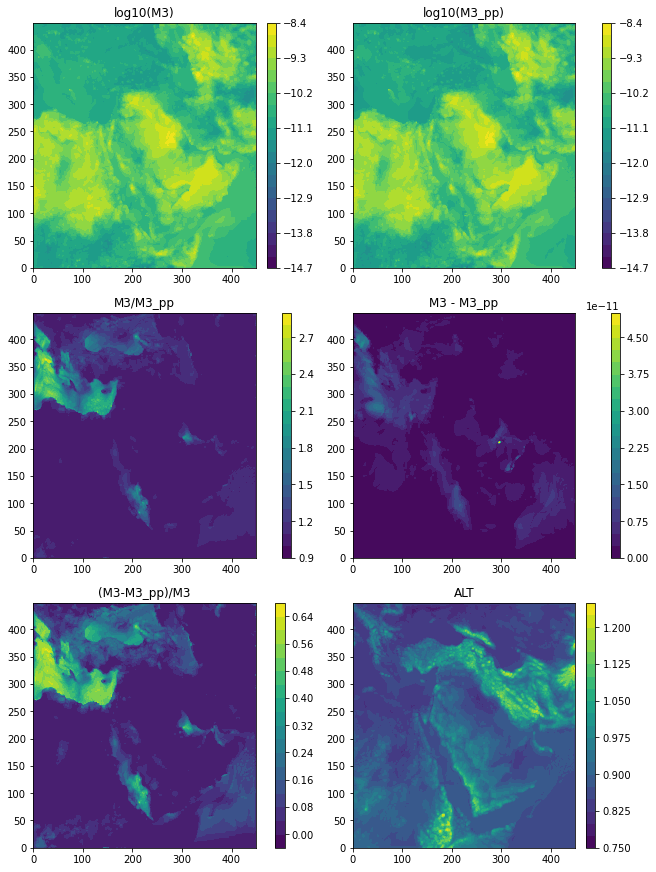

In [7]:
# dims: time, level, lat, lon

fig, axes = plt.subplots(constrained_layout=True, figsize=(9,12),
                         nrows=3, ncols=2)

plt.sca(axes[0,0])
plt.contourf(np.log10(m3[-1, 0]), levels=20)
plt.colorbar()
plt.title('log10(M3)')

plt.sca(axes[0,1])
plt.contourf(np.log10(m3_pp[-1, 0]), levels=20)
plt.colorbar()
plt.title('log10(M3_pp)')

plt.sca(axes[1,0])
plt.contourf(ratio[-1, 0], levels=20)
plt.colorbar()
plt.title('M3/M3_pp')

plt.sca(axes[1,1])
plt.contourf(diff[-1, 0], levels=20)
plt.colorbar()
plt.title('M3 - M3_pp')

plt.sca(axes[2,0])
plt.contourf(rel_diff[-1, 0], levels=20)
plt.colorbar()
plt.title('(M3-M3_pp)/M3')

plt.sca(axes[2,1])
plt.contourf(alt[-1, 0], levels=20)
plt.colorbar()
plt.title('ALT')

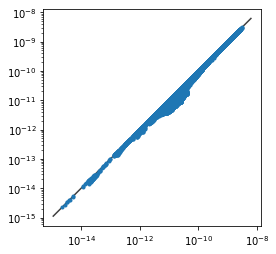

In [8]:
plt.figure()
plt.scatter(m3[-1, 0].flatten(), m3_pp[-1, 0].flatten(), marker='.')
plt.xscale('log')
plt.yscale('log')
ax = plt.gca()
lims = [ np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
# plt.plot([0,1],[0,1], 'k', transform=ax.transAxes)
ax.set_aspect('equal')

In [9]:
#       yextra_add(1,6) = cblk(1,vnu3 )*(pirs/6.0)*1.0e9/blkdens(1)   ! "n-m3-AP"/kg-air

# d**3 * pi/6 *10**9 * alt

# convfac2 = 1./alt(i,k,j)
#       blkdens(blksize) = convfac2
